In [1]:
import fasttext

In [2]:
import numpy as np
data = np.fromfile(
"/data/paloma/tokenized_paloma_c4_100_domains_validation.bin",
dtype=np.uint16
)

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
decoded_paloma = tokenizer.decode(data)
# save to file
with open("decoded_paloma.txt", "w") as f:
    f.write(decoded_paloma)

In [13]:
# clean newlines, whitespace, and empty strings from decoded_paloma
docs = [doc.strip().replace("\n", " ") for doc in decoded_paloma.split("<|endoftext|>") if doc.strip()]
len(docs)

14059

# Train a Paloma Classifier

In [14]:
# write fasttext file
with open("fasttext_paloma.txt", "w") as f:
    for doc in docs:
        f.write(f"__label__paloma {doc}\n")

In [15]:
import random
from collections import Counter
from typing import List, Tuple

def read_fasttext_file(filepath: str) -> List[str]:
    """Read FastText formatted file and return list of lines."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

def extract_label(line: str) -> str:
    """Extract label from FastText formatted line (assumes __label__xxx format)."""
    return line.split()[0]

def balance_data(data: List[str]) -> List[str]:
    """Balance the dataset by undersampling to match the minority class."""
    # group lines by label
    label_groups = {}
    for line in data:
        label = extract_label(line)
        if label not in label_groups:
            label_groups[label] = []
        label_groups[label].append(line)
    
    # find minimum class size
    min_size = min(len(group) for group in label_groups.values())
    
    print(f"Original distribution: {[(label, len(group)) for label, group in label_groups.items()]}")
    print(f"Balancing to {min_size} samples per class")
    
    # sample min_size examples from each class
    balanced_data = []
    for label, group in label_groups.items():
        balanced_data.extend(random.sample(group, min_size))
    
    return balanced_data

def shuffle_and_split_fasttext(file1_path: str, file2_path: str, 
                              train_split: float = 0.8, 
                              balance: bool = True,
                              output_train: str = 'train.txt',
                              output_test: str = 'test.txt',
                              random_seed: int = 42) -> None:
    """
    process two fasttext files: combine, shuffle, balance, and split.
    
    Args:
        file1_path: Path to first FastText file
        file2_path: Path to second FastText file  
        train_split: Fraction for training set (0.0 to 1.0)
        balance: Whether to balance classes by undersampling
        output_train: Output path for training set
        output_test: Output path for test set
        random_seed: Random seed for reproducibility
    """
    
    # set random seed for reproducibility
    random.seed(random_seed)
    
    # read both files
    print("reading files...")
    data1 = read_fasttext_file(file1_path)
    data2 = read_fasttext_file(file2_path)
    
    # combine data
    all_data = data1 + data2
    print(f"combined {len(data1)} + {len(data2)} = {len(all_data)} samples")
    
    # show original distribution
    labels = [extract_label(line) for line in all_data]
    print(f"label distribution: {Counter(labels)}")

    # rebalance classes
    if balance:
        all_data = balance_data(all_data)
        labels = [extract_label(line) for line in all_data]
        print(f"Balanced distribution: {Counter(labels)}")
    
    # shuffle the combined data
    random.shuffle(all_data)
    print("data shuffled")
    
    # split into train/test
    split_idx = int(len(all_data) * train_split)
    train_data = all_data[:split_idx]
    test_data = all_data[split_idx:]
    
    print(f"split: {len(train_data)} train, {len(test_data)} test")
    
    # check distribution in splits
    train_labels = [extract_label(line) for line in train_data]
    test_labels = [extract_label(line) for line in test_data]
    print(f"train distribution: {Counter(train_labels)}")
    print(f"test distribution: {Counter(test_labels)}")
    
    # write output files
    with open(output_train, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(output_test, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    
    print(f"Files saved: {output_train}, {output_test}")

In [17]:
shuffle_and_split_fasttext(
        file1_path='fasttext_paloma.txt',
        file2_path='negative_data.txt',
        train_split=0.9,
        balance=True,
        output_train='paloma.train',
        output_test='paloma.test',
        random_seed=42
    )

reading files...
combined 14059 + 20000 = 34059 samples
label distribution: Counter({'__label__low-quality': 20000, '__label__paloma': 14059})
Original distribution: [('__label__paloma', 14059), ('__label__low-quality', 20000)]
Balancing to 14059 samples per class
Balanced distribution: Counter({'__label__paloma': 14059, '__label__low-quality': 14059})
data shuffled
split: 25306 train, 2812 test
train distribution: Counter({'__label__paloma': 12676, '__label__low-quality': 12630})
test distribution: Counter({'__label__low-quality': 1429, '__label__paloma': 1383})
Files saved: paloma.train, paloma.test


In [18]:
model = fasttext.train_supervised(input='paloma.train', autotuneValidationFile='paloma.test')

Progress: 100.0% Trials:    9 Best score:  0.992532 ETA:   0h 0m 0s
Training again with best arguments
Read 18M words
Number of words:  1768055
Number of labels: 2
Progress: 100.0% words/sec/thread:  557501 lr:  0.000000 avg.loss:  0.010986 ETA:   0h 0m 0s


In [19]:
model.save_model("paloma_classifier.bin")

In [57]:
positive_test = read_fasttext_file("positive_data.txt")

In [58]:
labels, vals = model.predict(positive_test)
vals = [float(val) for val in vals]

/tmp/ipykernel_3384389/2847972384.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals = [float(val) for val in vals]


In [59]:
import matplotlib.pyplot as plt

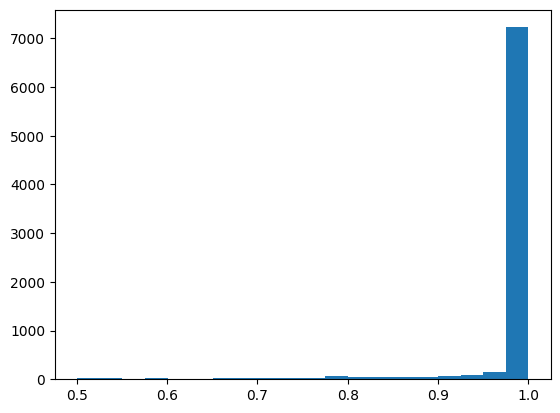

In [60]:
plt.hist(vals, bins = 20)
plt.show()

In [70]:
# look at examples of paloma-classified data
for i, label in enumerate(labels):
    if label[0] == '__label__paloma'

False